### Imports

In [1]:
import InceptionTime.load_data as dataloader
import InceptionTime.InceptionModule_keras
import InceptionTime.utils
import os
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import random
seed = 18
random.seed(seed)

### Load data

In [7]:
from pyts.datasets import ucr_dataset_list

# During development only choose a subset, to speed up load
DATASET_NAMES = ucr_dataset_list()[60:80]
print(DATASET_NAMES)

datasets_dict = {}
meta_data_dict = {'name': [], 'train_size': [], 'test_size':[] ,'length':[], 'test_proportion':[], "num_classes":[]}     # pandas dataframe with metadata about UCR datasets

CACHED_DATA_FOLDER = os.path.dirname(os.path.dirname(os.getcwd())) + "/Data"
for dataset_name in DATASET_NAMES:
    cache_path = os.path.join(CACHED_DATA_FOLDER, dataset_name)
    dataset_obj = dataloader.fetch_ucr_dataset(dataset=dataset_name, use_cache=True, data_home=cache_path)
    datasets_dict[dataset_name] = dataset_obj

    # Filter the datasets depending on number of classes
    num_classes = len(np.unique(dataset_obj['target_train']))
    #if num_clases < 3:
    
    data_length = dataset_obj['data_train'].shape[1]
    train_size = dataset_obj['data_train'].shape[0]
    test_size = dataset_obj['data_test'].shape[0]
    (labels,counts) = np.unique(dataset_obj['target_test'],return_counts=True)
    test_proportion = counts[0]/(counts[0]+counts[1])

    meta_data_dict['length'].append(data_length)
    meta_data_dict['train_size'].append(train_size)
    meta_data_dict['test_size'].append(test_size)
    meta_data_dict['name'].append(dataset_name)
    meta_data_dict['test_proportion'].append(test_proportion)
    meta_data_dict['num_classes'].append(num_classes)


meta_df = pd.DataFrame(data=meta_data_dict)


['InlineSkate', 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MelbournePedestrian', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxTW', 'MixedShapes', 'MixedShapesSmallTrain', 'MoteStrain', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2']


### Filter out too large datasets and split into three

In [13]:


reasonable_datasets = meta_df.loc[(meta_df['train_size']>200)&(meta_df['train_size']<2000)& (meta_df['test_size']<2*meta_df['train_size']) & (meta_df['length']<1000)]
print(reasonable_datasets)
split = int(reasonable_datasets.shape[0]/3)
print("sofia:\n", reasonable_datasets['name'][0:split].to_string(index=False).split())
print("ayman:\n", reasonable_datasets['name'][split:2*split].to_string(index=False).split())
print("nils:\n", reasonable_datasets['name'][2*split:].to_string(index=False).split())

print(meta_df)

                            name  train_size  test_size  length   
5         LargeKitchenAppliances         375        375     720  \
10                 MedicalImages         381        760      99   
12  MiddlePhalanxOutlineAgeGroup         400        154      80   
13   MiddlePhalanxOutlineCorrect         600        291      80   
14               MiddlePhalanxTW         399        154      80   
18    NonInvasiveFetalECGThorax1        1800       1965     750   
19    NonInvasiveFetalECGThorax2        1800       1965     750   

    test_proportion  num_classes  
5          0.500000            3  
10         0.606299           10  
12         0.296000            3  
13         0.429553            2  
14         0.362319            6  
18         0.551724           42  
19         0.551724           42  
sofia:
 ['LargeKitchenAppliances', 'MedicalImages']
ayman:
 ['MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect']
nils:
 ['MiddlePhalanxTW', 'NonInvasiveFetalECGThorax1', 'N

### Preprocess and Augment data

In [25]:
from sklearn.model_selection import train_test_split
from surrogate_augmentation import refined_AAFT_surrogates, correlated_noise_surrogates, white_noise_surrogates, AAFT_surrogates



def augment_data(X):
    n_iters = 10
    X_refined_AAFT = refined_AAFT_surrogates(X, n_iters)
    X_AAFT = AAFT_surrogates(X)
    X_correlated_noise = correlated_noise_surrogates(X)
    X_white_noise = white_noise_surrogates(X)
    return X_refined_AAFT, X_AAFT, X_correlated_noise, X_white_noise


def preprocess_data(dataset_name):
    processed_data_dict = {}
    #for name, dataset_object in datasets_dict.items():
    X = datasets_dict[dataset_name]['data_train']
    Y = datasets_dict[dataset_name]['target_train']
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, stratify=Y)
    x_test = datasets_dict[dataset_name]['data_test']
    y_test = datasets_dict[dataset_name]['target_test']

    x_refined_AAFT, x_AAFT, x_correlated_noise, x_white_noise = augment_data(x_train)

    num_classes = len(np.unique(np.concatenate((y_train, y_val, y_test), axis=0)))

    y_train, y_val, y_test = InceptionTime.utils.transform_labels(y_train, y_val, y_test)

    # save orignal y because later we will use binary
    y_test = y_test.astype(np.int64)
    y_train = y_train.astype(np.int64)
    y_val = y_val.astype(np.int64)

    # transform the labels from integers to one hot vectors
    enc = OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test, y_val), axis=0).reshape(-1, 1))
    y_train_onehot = enc.transform(y_train.reshape(-1, 1)).toarray()
    y_test_onehot = enc.transform(y_test.reshape(-1, 1)).toarray()
    y_val_onehot = enc.transform(y_val.reshape(-1, 1)).toarray()



    if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    processed_data_dict = {"x_train":x_train, "y_train":y_train, "y_train_onehot":y_train_onehot, 
                                "x_test":x_test, "y_test":y_test, "y_test_onehot":y_test_onehot,
                                "x_val":x_val, "y_val":y_val, "y_val_onehot":y_val_onehot,
                                "num_classes":num_classes, 
                                "x_refined_AAFT":x_refined_AAFT, "x_correlated_noise":x_correlated_noise, 
                                "x_AAFT":x_AAFT, "x_white_noise":x_white_noise}
    

    return processed_data_dict


### Pre-train on augmented data

In [23]:

N_EPOCHS = 10
N_ENSEMBLE = 2

pretrained_networks = {}

augmentation_types = ["x_train", "x_refined_AAFT"] #["x_refined_AAFT", "x_white_noise","x_train"]

#for name, dataset_object in processed_data_dict.items():

pretrain_metrics = {}

for name in ["LargeKitchenAppliances"]:

   for aug_type in augmentation_types:

      pretrain_metrics[aug_type] = {"loss":[], "recall":[], "precision":[], "accuracy":[], "f1_score":[]} 

      pretrained_networks[aug_type] = []

      for i in range(N_ENSEMBLE):

         # Do this for each ensemble member so that we get slightly different training sets for each?
         processed_data = preprocess_data(name)
         x_train = processed_data[aug_type]
         y_train_onehot = processed_data['y_train_onehot']

         num_classes = processed_data['num_classes']
         input_shape = (x_train.shape[1], 1)

         verbose = True
         use_residual = True

         print(i)
         checkpoints_path = ""
         inception_net = InceptionTime.InceptionModule_keras.Classifier_INCEPTION(checkpoints_path, input_shape, num_classes, save_weights=False, verbose=verbose, use_residual=use_residual)
         # Do not use validation data now because we only want to train a short while, and don't use early stopping etc
         history = inception_net.fit(x_train, y_train_onehot, processed_data['x_val'], processed_data['y_val_onehot'], nb_epochs=N_EPOCHS, plot_test_acc=True)

         # Save metrics
         pretrain_metrics[aug_type]['loss'].append(history.history['loss'])
         pretrain_metrics[aug_type]['accuracy'].append(history.history['accuracy'])
         pretrain_metrics[aug_type]['precision'].append(history.history['Precision'])
         pretrain_metrics[aug_type]['recall'].append(history.history['Recall'])
         pretrain_metrics[aug_type]['f1_score'].append(history.history['F1_score'])

         pretrained_networks[aug_type].append(inception_net)
   



c:\Users\sofia\Documents\skola\Project in Data Science\DD2430-Project-Course-in-Data-Science\src\surrogate_augmentation.py:180: RuntimeWarning: invalid value encountered in divide
  r_phases = r_fft / np.abs(r_fft)


0
Epoch 1/10
5/5 [==============================] - 29s 4s/step - loss: 0.9837 - accuracy: 0.5840 - F1_score: 0.2203 - Precision: 1.0000 - Recall: 0.1299 - val_loss: 1.1085 - val_accuracy: 0.3274 - val_F1_score: 0.0154 - val_Precision: 0.5000 - val_Recall: 0.0078 - lr: 0.0010
Epoch 2/10
5/5 [==============================] - 24s 5s/step - loss: 0.7537 - accuracy: 0.6794 - F1_score: 0.4327 - Precision: 1.0000 - Recall: 0.2767 - val_loss: 1.6385 - val_accuracy: 0.3274 - val_F1_score: 0.4932 - val_Precision: 1.0000 - val_Recall: 0.3273 - lr: 0.0010
Epoch 3/10
5/5 [==============================] - 23s 4s/step - loss: 0.7322 - accuracy: 0.6794 - F1_score: 0.3978 - Precision: 1.0000 - Recall: 0.2486 - val_loss: 2.1712 - val_accuracy: 0.3274 - val_F1_score: 0.4971 - val_Precision: 1.0000 - val_Recall: 0.3307 - lr: 0.0010
Epoch 4/10
5/5 [==============================] - 25s 5s/step - loss: 0.5896 - accuracy: 0.7748 - F1_score: 0.4546 - Precision: 1.0000 - Recall: 0.2948 - val_loss: 0.8485 - 

### Train network on real data

In [26]:

N_EPOCHS = 50
N_ENSEMBLE = 2

use_pretrained = True

trained_networks = {}
train_metrics = {}
val_metrics = {}

#for name, dataset_object in processed_data_dict.items():
for name in ["LargeKitchenAppliances"]:

   num_classes = processed_data['num_classes']

   for aug_type in augmentation_types:

      trained_networks[aug_type] = []

      train_metrics[aug_type] = {"loss":[], "recall":[], "precision":[], "accuracy":[], "f1_score":[]} 
      val_metrics[aug_type] = {"loss":[], "recall":[], "precision":[], "accuracy":[], "f1_score":[]} 

      for i in range(N_ENSEMBLE):
         print(i)

         checkpoints_path = ""
         processed_data = preprocess_data(name)
         x_train=processed_data['x_train']
         input_shape = x_train.shape[1:]


         if use_pretrained:
            inception_net = pretrained_networks[aug_type][i]
         else:
            inception_net = InceptionTime.InceptionModule_keras.Classifier_INCEPTION(checkpoints_path, input_shape, num_classes, save_weights=False, verbose=verbose, use_residual=use_residual)
 
         history = inception_net.fit(x_train, processed_data['y_train_onehot'], processed_data['x_val'], processed_data['y_val_onehot'], nb_epochs=N_EPOCHS, plot_test_acc=True)
   

         # Save metrics
         train_metrics[aug_type]['loss'].append(history.history['loss'])
         train_metrics[aug_type]['accuracy'].append(history.history['accuracy'])
         train_metrics[aug_type]['precision'].append(history.history['Precision'])
         train_metrics[aug_type]['recall'].append(history.history['Recall'])
         train_metrics[aug_type]['f1_score'].append(history.history['F1_score'])
         val_metrics[aug_type]['loss'].append(history.history['val_loss'])
         val_metrics[aug_type]['accuracy'].append(history.history['val_accuracy'])
         val_metrics[aug_type]['precision'].append(history.history['val_Precision'])
         val_metrics[aug_type]['recall'].append(history.history['val_Recall'])
         val_metrics[aug_type]['f1_score'].append(history.history['val_F1_score'])

         trained_networks[aug_type].append(inception_net)




0
Epoch 1/50
5/5 [==============================] - 23s 5s/step - loss: 0.2009 - accuracy: 0.9466 - F1_score: 0.4917 - Precision: 1.0000 - Recall: 0.3260 - val_loss: 0.7602 - val_accuracy: 0.6726 - val_F1_score: 0.4654 - val_Precision: 1.0000 - val_Recall: 0.3033 - lr: 0.0010
Epoch 2/50
5/5 [==============================] - 23s 4s/step - loss: 0.1876 - accuracy: 0.9502 - F1_score: 0.4887 - Precision: 1.0000 - Recall: 0.3234 - val_loss: 0.3937 - val_accuracy: 0.8407 - val_F1_score: 0.4785 - val_Precision: 1.0000 - val_Recall: 0.3145 - lr: 0.0010
Epoch 3/50
5/5 [==============================] - 23s 4s/step - loss: 0.1272 - accuracy: 0.9609 - F1_score: 0.4965 - Precision: 1.0000 - Recall: 0.3302 - val_loss: 0.3741 - val_accuracy: 0.8761 - val_F1_score: 0.4854 - val_Precision: 1.0000 - val_Recall: 0.3205 - lr: 0.0010
Epoch 4/50
5/5 [==============================] - 22s 4s/step - loss: 0.1341 - accuracy: 0.9609 - F1_score: 0.4988 - Precision: 1.0000 - Recall: 0.3323 - val_loss: 0.3172 - 

### Plot learning curves

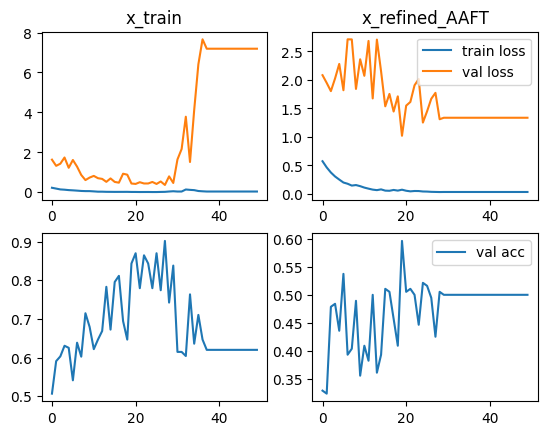

In [28]:
from matplotlib import pyplot as plt

augmentation_types = ["x_train", "x_refined_AAFT"]

fig, axs = plt.subplots(2, len(augmentation_types))


for j,aug_type in enumerate(augmentation_types):
    for i in range(N_ENSEMBLE):
        epochs = len(train_metrics[aug_type]['loss'][i])
        if epochs<N_EPOCHS:
            for metric in train_metrics[aug_type].keys():
                train_metrics[aug_type][metric][i]= np.pad(train_metrics[aug_type][metric][i], (0,N_EPOCHS-epochs), constant_values=train_metrics[aug_type][metric][i][epochs-1])
                val_metrics[aug_type][metric][i] = np.pad(val_metrics[aug_type][metric][i], (0,N_EPOCHS-epochs), constant_values=val_metrics[aug_type][metric][i][epochs-1])


for i in range(len(augmentation_types)):
    aug_type=augmentation_types[i]
    axs[0,i].plot([i for i in range(N_EPOCHS)], np.mean(train_metrics[aug_type]['loss'], axis=0) , label="train loss")
    axs[0,i].plot([i for i in range(N_EPOCHS)], np.mean(val_metrics[aug_type]['loss'],axis=0), label="val loss")
    axs[0,i].set_title(aug_type)
    axs[1,i].plot([i for i in range(N_EPOCHS)], np.mean(val_metrics[aug_type]['accuracy'], axis=0), label="val acc")

axs[0,i].legend()
axs[1,i].legend()



plt.show()



# For the whole ensemble, are the metrics just the mean of the individual networks?

In [ ]:
for aug_type in augmentation_types:
    all_preds = np.zeros_like(processed_data['y_test_onehot'])
    for i in range(N_ENSEMBLE):
        network = trained_networks[aug_type][i]
        prediction = network.predict(processed_data['x_test'], False)
        all_preds += prediction/N_ENSEMBLE
    metrics = InceptionTime.utils.calculate_metrics(processed_data['y_test'], np.argmax(all_preds, axis=1),0.0)
    print(aug_type)
    print(metrics)
    